In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import torch
import copy
# import torch_directml
# import lightning as L

In [2]:
torch.version.cuda
print(torch.version.cuda)

None


### Feature extraction

In [2]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
# print(config['data']['frame_size'])

fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [3]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        n_input_channel = 1        
        self.X = np.zeros((20000, n_input_channel, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,2))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(0),num_classes=2)
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:,:] = np.reshape(X_spec[:,n:n+supra_frame_length],(n_input_channel,n_mel_channels,supra_frame_length))
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index,:] = torch.nn.functional.one_hot(torch.tensor(1),num_classes=2)
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete, axis=0)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

        self.y = torch.from_numpy(self.y)
        self.X = torch.from_numpy(self.X)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.X = self.X.to(device)
        self.y = self.y.to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index,:]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


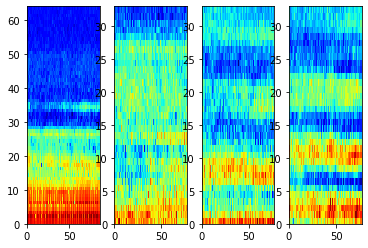

In [5]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(13202)

fig,ax = plt.subplots()
plt.subplot(141)
plt.pcolor(X_generic[0,:,:], cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)

## NN
conv_lf = torch.nn.Conv2d(1,3,(32,10),padding='valid',dtype=torch.float)

input = torch.tensor(X_generic,dtype=torch.float)
output = conv_lf(input)
output_np = output.detach().numpy()
plt.subplot(142)
plt.pcolor(output_np[0,:,:], cmap='jet')
plt.subplot(143)
plt.pcolor(output_np[1,:,:], cmap='jet')
plt.subplot(144)
plt.pcolor(output_np[2,:,:], cmap='jet')

#### CNN1-model

In [12]:
class ALS_CNN1(nn.Module):
    def __init__(self):
        super(ALS_CNN1,self).__init__() 
        # parameters
        # file = open("drive/MyDrive/Colab Notebooks/config.json")
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        input_chan = 2
        frames_in_segment = frames_in_segment - 1 # only for model with diff input
        self.layer1_filt = 1
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        # low/medium/high-frequency frequency span
        # low/medium/high-frequency time span
        lf1_height, lf1_width = 29,43
        lf2_height, lf2_width = 29,43 #13,27
        lf3_height, lf3_width = 29,43 #5,11
        lf4_height, lf4_width = 29,43 #3,7

        mf1_height,mf1_width = 15,43 #15,31
        mf2_height,mf2_width = 11,31 #13,27
        mf3_height,mf3_width = 15,43
        mf4_height,mf4_width = 15,43

        hf1_height,hf1_width = 15,31    
        hf2_height,hf2_width = 13,27
        hf3_height,hf3_width = 15,31 #9,15
        hf4_height,hf4_width = 15,31 #3,3
        
        lf1_h_stride, lf1_w_stride = lf1_height//2, lf1_width//2
        lf2_h_stride, lf2_w_stride = lf2_height//2, lf2_width//2
        lf3_h_stride, lf3_w_stride = lf3_height//2, lf3_width//2
        lf4_h_stride, lf4_w_stride = lf4_height//2, lf4_width//2

        mf1_h_stride, mf1_w_stride = mf1_height//2, mf1_width//2
        mf2_h_stride, mf2_w_stride = mf2_height//2, mf2_width//2
        mf3_h_stride, mf3_w_stride = mf3_height//2, mf3_width//2
        mf4_h_stride, mf4_w_stride = mf4_height//2, mf4_width//2

        hf1_h_stride, hf1_w_stride = hf1_height//2, hf1_width//2
        hf2_h_stride, hf2_w_stride = hf2_height//2, hf2_width//2
        hf3_h_stride, hf3_w_stride = hf3_height//2, hf3_width//2
        hf4_h_stride, hf4_w_stride = hf4_height//2, hf4_width//2

        self.batch_norm1 = nn.BatchNorm2d(input_chan)    # device='cuda'
        
        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf1_height, lf1_width),padding='valid',stride=(lf1_h_stride, lf1_w_stride))
        self.conv_lf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf2_height, lf2_width),padding='valid',stride=(lf2_h_stride, lf2_w_stride))
        self.conv_lf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf3_height, lf3_width),padding='valid',stride=(lf3_h_stride, lf3_w_stride))
        self.conv_lf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(lf4_height, lf4_width),padding='valid',stride=(lf4_h_stride, lf4_w_stride))

        self.conv_mf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf1_height, mf1_width),padding='valid',stride=(mf1_h_stride, mf1_w_stride))
        self.conv_mf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf2_height, mf2_width),padding='valid',stride=(mf2_h_stride, mf2_w_stride))
        self.conv_mf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf3_height, mf3_width),padding='valid',stride=(mf3_h_stride, mf3_w_stride))
        self.conv_mf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(mf4_height, mf4_width),padding='valid',stride=(mf4_h_stride, mf4_w_stride))

        self.conv_hf1 = torch.nn.Conv2d(input_chan,self.layer1_filt,(hf1_height, hf1_width),padding='valid',stride=(hf1_h_stride, hf1_w_stride))
        self.conv_hf2 = torch.nn.Conv2d(input_chan,self.layer1_filt,(hf2_height, hf2_width),padding='valid',stride=(hf2_h_stride, hf2_w_stride))
        self.conv_hf3 = torch.nn.Conv2d(input_chan,self.layer1_filt,(hf3_height, hf3_width),padding='valid',stride=(hf3_h_stride, hf3_w_stride))
        self.conv_hf4 = torch.nn.Conv2d(input_chan,self.layer1_filt,(hf4_height, hf4_width),padding='valid',stride=(hf4_h_stride, hf4_w_stride))

        max_pool_width = 1
        self.maxpool_lf1 = nn.MaxPool2d(((self.lf_num - lf1_height)//lf1_h_stride + 1,max_pool_width))        
        self.maxpool_lf2 = nn.MaxPool2d(((self.lf_num - lf2_height)//lf2_h_stride + 1,max_pool_width))
        self.maxpool_lf3 = nn.MaxPool2d(((self.lf_num - lf3_height)//lf3_h_stride + 1,max_pool_width))
        self.maxpool_lf4 = nn.MaxPool2d(((self.lf_num - lf3_height)//lf4_h_stride + 1,max_pool_width))

        self.maxpool_mf1 = nn.MaxPool2d(((self.mf_num - mf1_height)//mf1_h_stride + 1,max_pool_width))
        self.maxpool_mf2 = nn.MaxPool2d(((self.mf_num - mf2_height)//mf2_h_stride + 1,max_pool_width))
        self.maxpool_mf3 = nn.MaxPool2d(((self.mf_num - mf3_height)//mf3_h_stride + 1,max_pool_width))
        self.maxpool_mf4 = nn.MaxPool2d(((self.mf_num - mf4_height)//mf4_h_stride + 1,max_pool_width))

        self.maxpool_hf1 = nn.MaxPool2d(((self.hf_num - hf1_height)//hf1_h_stride + 1,max_pool_width))
        self.maxpool_hf2 = nn.MaxPool2d(((self.hf_num - hf2_height)//hf2_h_stride + 1,max_pool_width))
        self.maxpool_hf3 = nn.MaxPool2d(((self.hf_num - hf3_height)//hf3_h_stride + 1,max_pool_width))
        self.maxpool_hf4 = nn.MaxPool2d(((self.hf_num - hf4_height)//hf4_h_stride + 1,max_pool_width))

        self.drop1 = nn.Dropout(p=0.1)                        

        self.fc = nn.Linear(
                            self.layer1_filt*((1+(frames_in_segment-lf1_width)//lf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf2_width)//lf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf3_width)//lf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-lf4_width)//lf4_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf1_width)//mf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf2_width)//mf2_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf3_width)//mf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-mf4_width)//mf4_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-hf1_width)//hf1_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-hf2_width)//hf2_w_stride)//max_pool_width) + 
                            self.layer1_filt*((1+(frames_in_segment-hf3_width)//hf3_w_stride)//max_pool_width) +
                            self.layer1_filt*((1+(frames_in_segment-hf4_width)//hf4_w_stride)//max_pool_width)
                            ,2)                               

        torch.manual_seed(151)
        nn.init.xavier_uniform_(self.conv_lf1.weight)
        nn.init.xavier_uniform_(self.conv_lf2.weight)
        nn.init.xavier_uniform_(self.conv_lf3.weight)
        nn.init.xavier_uniform_(self.conv_lf4.weight)
        nn.init.xavier_uniform_(self.conv_mf1.weight)
        nn.init.xavier_uniform_(self.conv_mf2.weight)
        nn.init.xavier_uniform_(self.conv_mf3.weight)
        nn.init.xavier_uniform_(self.conv_mf4.weight)
        nn.init.xavier_uniform_(self.conv_hf1.weight)
        nn.init.xavier_uniform_(self.conv_hf2.weight)
        nn.init.xavier_uniform_(self.conv_hf3.weight)
        nn.init.xavier_uniform_(self.conv_hf4.weight)
        nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x): 
        
        # print('x size', x.shape)
        x_diff = x[:,:,:,1:] - x[:,:,:,0:-1]
        # print('x_diff', x_diff.shape)
        # print('x', x[:,:,:,1:].shape)
        out = torch.cat((x[:,:,:,1:],x_diff), dim=1)
        # print('x merge', out.shape)

        out = self.batch_norm1(out)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]
        
        out_lf2 = out1.detach()
        out_lf3 = out1.detach()
        out_lf4 = out1.detach()

        out_mf2 = out2.detach()
        out_mf3 = out2.detach()
        out_mf4 = out2.detach()
        
        out_hf2 = out3.detach()
        out_hf3 = out3.detach()
        out_hf4 = out3.detach()

        # for param in self.conv_lf.parameters():
        #     print(param.data)
        #     print(param.data.shape)
        # print(self.conv_lf.weight())        
        
        
        out1 = torch.nn.functional.elu(self.conv_lf1(out1))
        out_lf2 = torch.nn.functional.elu(self.conv_lf2(out_lf2))
        out_lf3 = torch.nn.functional.elu(self.conv_lf3(out_lf3))
        out_lf4 = torch.nn.functional.elu(self.conv_lf4(out_lf4))

        out2 = torch.nn.functional.elu(self.conv_mf1(out2))
        out_mf2 = torch.nn.functional.elu(self.conv_mf2(out_mf2))
        out_mf3 = torch.nn.functional.elu(self.conv_mf3(out_mf3))
        out_mf4 = torch.nn.functional.elu(self.conv_mf4(out_mf4))

        out3 = torch.nn.functional.elu(self.conv_hf1(out3))
        out_hf2 = torch.nn.functional.elu(self.conv_hf2(out_hf2))
        out_hf3 = torch.nn.functional.elu(self.conv_hf3(out_hf3))
        out_hf4 = torch.nn.functional.elu(self.conv_hf4(out_hf4))

        out1 = self.maxpool_lf1(out1)        
        out_lf2 = self.maxpool_lf2(out_lf2)
        out_lf3 = self.maxpool_lf3(out_lf3)
        out_lf4 = self.maxpool_lf4(out_lf4)

        out2 = self.maxpool_mf1(out2)
        out_mf2 = self.maxpool_mf2(out_mf2)
        out_mf3 = self.maxpool_mf3(out_mf3)
        out_mf4 = self.maxpool_mf4(out_mf4)

        out3 = self.maxpool_hf1(out3)
        out_hf2 = self.maxpool_hf2(out_hf2)
        out_hf3 = self.maxpool_hf3(out_hf3)
        out_hf4 = self.maxpool_hf4(out_hf4)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out_lf2 = out_lf2.view(-1, out_lf2.shape[1]*out_lf2.shape[2]*out_lf2.shape[3])
        out_lf3 = out_lf3.view(-1, out_lf3.shape[1]*out_lf3.shape[2]*out_lf3.shape[3])
        out_lf4 = out_lf4.view(-1, out_lf4.shape[1]*out_lf4.shape[2]*out_lf4.shape[3])

        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out_mf2 = out_mf2.view(-1, out_mf2.shape[1]*out_mf2.shape[2]*out_mf2.shape[3])
        out_mf3 = out_mf3.view(-1, out_mf3.shape[1]*out_mf3.shape[2]*out_mf3.shape[3])
        out_mf4 = out_mf4.view(-1, out_mf4.shape[1]*out_mf4.shape[2]*out_mf4.shape[3])

        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])
        out_hf2 = out_hf2.view(-1, out_hf2.shape[1]*out_hf2.shape[2]*out_hf2.shape[3])
        out_hf3 = out_hf3.view(-1, out_hf3.shape[1]*out_hf3.shape[2]*out_hf3.shape[3])
        out_hf4 = out_hf4.view(-1, out_hf4.shape[1]*out_hf4.shape[2]*out_hf4.shape[3])

        out = torch.cat((out1, out_lf2, out_lf3, out_lf4, 
                         out2, out_mf2, out_mf3, out_mf4, 
                         out3, out_hf2, out_hf3, out_hf4
                         ), 1)  

        out = self.drop1(out)
        
        # print('fc.weight: ', self.fc.weight.shape)
        # print('out: ', out.shape)

        out = self.fc(out)
        return out  

#### CNN2-model

In [5]:
class ALS_CNN(nn.Module):
    def __init__(self):
        super(ALS_CNN,self).__init__() 
        # parameters
        file = open("drive/MyDrive/Colab Notebooks/config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        frames_in_segment = config['data']['supra_frame_length']
        layer1_filt = 18
        layer2_filt = 8
        
        self.lf_num = 32    # low-frequency
        self.mf_num = 16    # medium-frequency
        self.hf_num = 16    # high-frequency
        
        lf_width,  mf_width,  hf_width  = 48,36,16      # low/medium/high-frequency time span
        lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span

        l2_kernel_size = 5

        lf_h_stride, mf_h_stride, hf_h_stride = 2,1,1
        lf_w_stride, mf_w_stride, hf_w_stride = 4, 4, 4

        self.batch_norm1 = nn.BatchNorm2d(1)
        
        self.batch_norm_lf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_mf = nn.BatchNorm2d(layer1_filt)
        self.batch_norm_hf = nn.BatchNorm2d(layer1_filt)

        # self.conv_lf = torch.nn.Conv2d(1,self.layer1_filt,(self.lf_num, lf_width),padding='valid',stride=(1,lf_width//2))
        # self.conv_mf = torch.nn.Conv2d(1,self.layer1_filt,(self.mf_num, mf_width),padding='valid',stride=(1,mf_width//2))
        # self.conv_hf = torch.nn.Conv2d(1,self.layer1_filt,(self.hf_num, hf_width),padding='valid',stride=(1,hf_width//2))

        self.conv_lf = torch.nn.Conv2d(1,layer1_filt,(lf_height, lf_width),padding='valid',stride=(lf_h_stride,lf_w_stride))
        self.conv_mf = torch.nn.Conv2d(1,layer1_filt,(mf_height, mf_width),padding='valid',stride=(mf_h_stride,mf_w_stride))
        self.conv_hf = torch.nn.Conv2d(1,layer1_filt,(hf_height, hf_width),padding='valid',stride=(hf_h_stride,hf_w_stride))

        self.conv2_lf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_mf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))
        self.conv2_hf = torch.nn.Conv2d(layer1_filt, layer2_filt,l2_kernel_size,padding='valid',stride=(1,1))

        self.maxpool_lf = nn.MaxPool2d(((self.lf_num - lf_height)//lf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_mf = nn.MaxPool2d(((self.mf_num - mf_height)//mf_h_stride + 1 - (l2_kernel_size-1),1))
        self.maxpool_hf = nn.MaxPool2d(((self.hf_num - hf_height)//hf_h_stride + 1 - (l2_kernel_size-1),1))

        self.drop1 = nn.Dropout(p=0.05)
        
        self.fc = nn.Linear(layer2_filt*(1+((frames_in_segment-lf_width)//lf_w_stride) - (l2_kernel_size-1)) + # *(1+(self.lf_num-lf_height)//lf_height)
                            layer2_filt*(1+((frames_in_segment-mf_width)//mf_w_stride) - (l2_kernel_size-1)) + #*(1+(self.mf_num-mf_height)//mf_height) + 
                            layer2_filt*(1+((frames_in_segment-hf_width)//hf_w_stride) - (l2_kernel_size-1)) #*(1+(self.hf_num-hf_height)//hf_height)
                            ,1)    # 16 = np.round(()/5).astype(int)                                  

        torch.manual_seed(151)
        # nn.init.xavier_uniform_(self.conv_lf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_mf.weight, gain=1.0)
        # nn.init.xavier_uniform_(self.conv_hf.weight, gain=1.0)

        nn.init.kaiming_normal_(self.conv_lf.weight)
        nn.init.kaiming_normal_(self.conv_mf.weight)
        nn.init.kaiming_normal_(self.conv_hf.weight)

        nn.init.kaiming_normal_(self.conv2_lf.weight)
        nn.init.kaiming_normal_(self.conv2_mf.weight)
        nn.init.kaiming_normal_(self.conv2_hf.weight)

        nn.init.xavier_normal_(self.fc.weight)
    
    def forward(self, x): 
        
        out = self.batch_norm1(x)

        out1 = out[:,:,:self.lf_num,:]
        out2 = out[:,:,self.lf_num:self.lf_num+self.mf_num,:]
        out3 = out[:,:,self.lf_num+self.mf_num:self.lf_num+self.mf_num+self.hf_num,:]

        out1 = torch.relu(self.conv_lf(out1))
        out2 = torch.relu(self.conv_mf(out2))
        out3 = torch.relu(self.conv_hf(out3))
        
        out1 = self.batch_norm_lf(out1)
        out2 = self.batch_norm_mf(out2)
        out3 = self.batch_norm_hf(out3)

        out1 = torch.relu(self.conv2_lf(out1))
        out2 = torch.relu(self.conv2_mf(out2))
        out3 = torch.relu(self.conv2_hf(out3))

        out1 = self.maxpool_lf(out1)        
        out2 = self.maxpool_mf(out2)
        out3 = self.maxpool_hf(out3)

        out1 = out1.view(-1, out1.shape[1]*out1.shape[2]*out1.shape[3])
        out2 = out2.view(-1, out2.shape[1]*out2.shape[2]*out2.shape[3])
        out3 = out3.view(-1, out3.shape[1]*out3.shape[2]*out3.shape[3])

        # print('After view 1:', out1.shape)

        out = torch.cat((out1,out2,out3), 1)  

        # print('After cat:', out.shape)

        out = self.drop1(out)

        out = self.fc(out)
        return out

#### training_loop

In [5]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/model_cnn.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    lrs = []
    for epoch in range(1,n_epochs+1):        
        model.train()
        loss_val_best = 0
        loss_train = 0.0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)                        
            outputs = outputs.squeeze(dim=1) # for batch train_loader 
            # print('output:',outputs)
            # print('labels:',labels)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()            
        
        # prediction on val set        
        loss_val = 0.0
        TP_TN_sum = 0
        total = 0
        model.eval()
        with torch.no_grad():            
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)                                
                pred = torch.squeeze(pred,1)                

                loss = loss_fn(pred, label)
                loss_val += loss.item()

                _,pred = torch.max(pred, dim=1)
                _,label = torch.max(label, dim=1)
                        
                total += len(label)

                TP_TN_sum = TP_TN_sum + torch.sum(label==pred)

        acc_val = TP_TN_sum/total
        
        loss_train_history[epoch-1] = loss_train / len(train_loader)
        loss_val_history[epoch-1] = loss_val / len(val_loader)


        if loss_val > loss_val_best:
            torch.save(model.state_dict(), MODEL_PATH)            
            loss_val_best = loss_val

        # if epoch==1 or epoch%2==0:                                                            
        print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
        
        lrs.append(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()
        
    # model = torch.load(MODEL_PATH)
    model.load_state_dict(torch.load(MODEL_PATH))

    fig, ax = plt.subplots(figsize=(6,2.5))
    plt.rcParams.update({'font.size': 12})
    # plt.subplot(1,2,1)
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    # plt.subplot(1,2,2)
    # plt.plot(range(len(lrs)),lrs)
    # plt.xlabel('step')
    # plt.ylabel('lr')    
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)
    return (loss_train_history,loss_val_history)

### Single NN training & evaluation

In [45]:
# Test inference
model = ALS_CNN1()
X, y = DataSet_ALS.__getitem__(13202)
input = torch.tensor(X, dtype=torch.float)
input = input.unsqueeze(0)  # add batch dimension
print(input.shape)
y_out = model(input)

torch.Size([1, 1, 64, 86])
fc.weight:  torch.Size([2, 600])
out:  torch.Size([1, 600])


C:\Users\Tanya\AppData\Local\Temp\ipykernel_13004\2400804641.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(X, dtype=torch.float)


In [ ]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

# model = ALS_FFNN()
model = ALS_CNN()
model.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=2e-5, weight_decay=2e-1)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    lr_scheduler = scheduler,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

### Train with 5-fold CV

#### crossvalid

In [24]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        torch.manual_seed(707)
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    # print(layer.weight())
                    layer.reset_parameters()
                    # print(layer.weight())
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                # spec = spec.squeeze()
                pred = model(spec)
                pred = torch.squeeze(pred,1)  
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### k_fold_CV

In [6]:
def k_fold_CV(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)
    folds = list([4,3,2,1,0])

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

    PATH = 'model_backup' + os.sep + 'cnn_init.pt'
    PATH_optim = 'model_backup'+os.sep+'cnn_optim_init.pt'
    PATH_lr = 'model_backup' + os.sep + 'cnn_lr_schedule_init.pt'

    torch.save(model.state_dict(), PATH)
    torch.save(optimizer.state_dict(), PATH_optim)
    torch.save(scheduler.state_dict(), PATH_lr)

    loss_train_history_list = list()
    loss_val_history_list = list()
    fold_acc = list()
    for i in folds: #range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=100,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=100, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        model.load_state_dict(torch.load(PATH))
        optimizer.load_state_dict(torch.load(PATH_optim))
        scheduler.load_state_dict(torch.load(PATH_lr))

        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()        

        loss_train_history, loss_val_history = train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            lr_scheduler = scheduler,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        loss_train_history_list.append(loss_train_history)
        loss_val_history_list.append(loss_val_history)

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                pred = model(spec)
                # pred = torch.squeeze(pred,1)
                pred = torch.squeeze(pred)
                pred = torch.squeeze(pred)  
                label = torch.squeeze(label,0)
                
                # print('pred.shape', pred.shape)
                # print('pred', pred)
                # print('label.shape', label.shape)
                # print('label', label)

                # test_score.append(pred.numpy())
                test_score.append(pred[1].numpy())
                if pred[1]>pred[0]: #pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                    if label[1]>label[0]:
                        TP_TN_sum +=1    # TP
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0 
                    if label[0]>label[1]:
                        TP_TN_sum +=1    # TN                   
                y_true[inds_test[i]] = 1*(label[1]>label[0]) #label

                # if pred==label:
                #     TP_TN_sum +=1                
                i +=1
            fold_acc.append(TP_TN_sum/len(test_score))
            print('Acc = ', TP_TN_sum/len(test_score))

    fig, ax = plt.subplots(figsize=(12,2.5))
    plt.rcParams.update({'font.size': 10})    

    for i in folds:
        plt.subplot(1,len(folds),i+1)
        plt.plot(range(n_epochs), loss_train_history_list[i], label='Обучающий набор')
        plt.plot(range(n_epochs), loss_val_history_list[i], label='Проверочный набор')
        plt.legend()
        plt.xlabel('Эпоха')
        plt.ylabel('Ошибка обучения')
    

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    
    print('Final results')
    print(f'{n_epochs} epochs. Acc_sk = {acc_sk:.2f} (Sens = {sensetivity:.2f} / Spec = {specificity:.2f}) {fold_acc[0]:.2f} / {fold_acc[1]:.2f} / {fold_acc[2]:.2f} / {fold_acc[3]:.2f} / {fold_acc[4]:.2f}')
    # print(f'Prec = {prec:.2f}')
    # print(f'Recall = {recall:.2f}')
    # print(f'')    
    
    # return acc_sk

#### Start script

In [ ]:
# script with reset.parameters()
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=2e-3) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = model, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

#### Start k-fold CV

In [ ]:
# dir_HC = '../wav'+ os.sep + 'HC' + os.sep
# dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# Start parameters
# layer1_filt = 64
# lf_num, mf_num, hf_num = 32,16,16    # low-frequency / medium-frequency / high-frequency       
# lf_width,  mf_width,  hf_width  = 12,8,4      # low/medium/high-frequency time span
# lf_height, mf_height, hf_height = 16,8,8      # low/medium/high-frequency frequency span
# lf_h_stride, mf_h_stride, hf_h_stride = 4,2,1
# lf_w_stride, mf_w_stride, hf_w_stride = lf_width//2, mf_width//2, hf_width//2
# optimizer = optim.Adam(model.parameters(),lr=1e-2, weight_decay=1e-1) # 30 epochs. Acc_sk = 0.56 (Sens = 0.47 / Spec = 0.65) 0.66 / 0.37 / 0.64 / 0.62 / 0.55
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.66) 0.65 / 0.82 / 0.72 / 0.78 / 0.61
# lf_height = 24
# optimizer = optim.SGD(model.parameters(),lr=1e-2, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.63 (Sens = 0.75 / Spec = 0.51) 0.72 / 0.71 / 0.59 / 0.63 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.61 (Sens = 0.73 / Spec = 0.49) 0.62 / 0.68 / 0.57 / 0.64 / 0.57
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.75 (Sens = 0.78 / Spec = 0.71) 0.68 / 0.85 / 0.66 / 0.68 / 0.87 (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 30 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.71 / 0.82 / 0.73 / 0.67 / 0.86
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.73 / 0.88 / 0.67 / 0.65 / 0.87
# mf_height = 12 (old val 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.73) 0.80 / 0.88 / 0.70 / 0.65 / 0.84
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.77 / 0.86 / 0.71 / 0.64 / 0.73
# hf_height = 12 (old val 8) 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.70) 0.67 / 0.89 / 0.65 / 0.66 / 0.810
# hf_height = 8 (return), mf_height = 16 (old val 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.71) 0.83 / 0.92 / 0.58 / 0.65 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 100 epochs. Acc_sk = 0.65 (Sens = 0.64 / Spec = 0.66) 0.62 / 0.73 / 0.58 / 0.72 / 0.66
# lf_width = 24 (old value 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.82 / Spec = 0.70) 0.84 / 0.93 / 0.60 / 0.64 / 0.85
# mf_width = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.77 / 0.89 / 0.59 / 0.67 / 0.91
# hf_height = 16 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.73) 0.68 / 0.89 / 0.58 / 0.75 / 0.94
# mf_height = 15 (old value 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.80 / Spec = 0.70) 0.70 / 0.86 / 0.57 / 0.75 / 0.94
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.64 / 0.84 / 0.55 / 0.75 / 0.85
# lf_width = 48 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.68 / 0.84 / 0.55 / 0.74 / 0.89
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 32 (24 old value)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.79 / Spec = 0.69) 0.69 / 0.87 / 0.54 / 0.75 / 0.90
# lf_width = 24 (return) + hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.76 / 0.87 / 0.54 / 0.69 / 0.87
# mf_height = 12 (before 16)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.78 (Sens = 0.82 / Spec = 0.74) 0.80 / 0.85 / 0.68 / 0.65 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.79 / 0.86 / 0.64 / 0.65 / 0.76
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.68) 0.69 / 0.67 / 0.64 / 0.67 / 0.85
# hf_height = 12 (old value 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.65 / 0.86 / 0.65 / 0.68 / 0.88
# hf_height = 8 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.77 (Sens = 0.81 / Spec = 0.72) 0.76 / 0.86 / 0.68 / 0.65 / 0.88
# hf_height = 10 (8 before)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.79 / Spec = 0.72) 0.75 / 0.85 / 0.64 / 0.66 / 0.87
# hf_height = 8 (return) + hf_width = 8 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.79 / 0.86 / 0.64 / 0.63 / 0.76
# return to model with 78% Acc
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.75 / 0.83 / 0.66 / 0.65 / 0.83
# xavier_uniform changed to kaiming_normal_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.63 / 0.88 / 0.53 / 0.75 / 0.94 (good behaviour)
# kaiming_normal_ changed to kaiming_uniform_
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.75 / Spec = 0.65) 0.62 / 0.87 / 0.53 / 0.77 / 0.79
# kaiming_uniform_ 
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.69) 0.65 / 0.88 / 0.53 / 0.75 / 0.95
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.80 / Spec = 0.68) 0.69 / 0.80 / 0.54 / 0.75 / 0.93
# hf_width = 5 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.74 (Sens = 0.78 / Spec = 0.69) 0.65 / 0.84 / 0.58 / 0.74 / 0.90
# xavier_uniform (return) + nn.init.xavier_uniform_(self.fc)
# optimizer = optim.SGD(model.parameters(),lr=5e-4, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.67 (Sens = 0.67 / Spec = 0.66) 0.60 / 0.65 / 0.62 / 0.64 / 0.82 (slow curves)
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.2) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.69) 0.75 / 0.83 / 0.58 / 0.66 / 0.79 
# optimizer = optim.SGD(model.parameters(),lr=2e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.72 / Spec = 0.67) 0.74 / 0.79 / 0.60 / 0.66 / 0.73
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.71) 0.72 / 0.88 / 0.60 / 0.66 / 0.84
# lf_width = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.76 (Sens = 0.78 / Spec = 0.73) 0.77 / 0.86 / 0.67 / 0.65 / 0.83
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.73 / 0.65 / 0.74
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.79 / Spec = 0.70) 0.78 / 0.90 / 0.73 / 0.65 / 0.74
# lf_height = 27 (before 24)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)
# mf_height = 15 (before 12)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.80 / Spec = 0.70) 0.79 / 0.90 / 0.71 / 0.65 / 0.75
# mf_width, mf_height = 13,13
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.74 (Sens = 0.81 / Spec = 0.66) 0.81 / 0.94 / 0.65 / 0.65 / 0.74
# mf_width, mf_height = 15,15 (return)
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.62 (Sens = 0.60 / Spec = 0.65) 0.50 / 0.74 / 0.59 / 0.72 / 0.63
# hf_width,hf_height = 5,5
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.82 / Spec = 0.59) 0.76 / 0.91 / 0.55 / 0.65 / 0.75
# mf_height,mf_width = 15,17 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.76 / Spec = 0.66) 0.68 / 0.74 / 0.56 / 0.67 / 0.87
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.73 (Sens = 0.80 / Spec = 0.65) 0.70 / 0.77 / 0.59 / 0.67 / 0.87
# self.layer1_filt = 3 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.82 / Spec = 0.65) 0.72 / 0.82 / 0.57 / 0.74 / 0.84
# self.layer1_filt = 2 (before 3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.73 / Spec = 0.70) 0.70 / 0.71 / 0.60 / 0.64 / 0.89
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 30 epochs. Acc_sk = 0.73 (Sens = 0.77 / Spec = 0.69) 0.75 / 0.79 / 0.60 / 0.65 / 0.84
# optimizer = optim.Adam(model.parameters(),lr=1e-3, weight_decay=1e-1) # 15 epochs. Acc_sk = 0.65 (Sens = 0.69 / Spec = 0.61) 0.62 / 0.81 / 0.57 / 0.71 / 0.62
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.8) # 15 epochs. Acc_sk = 0.72 (Sens = 0.74 / Spec = 0.70) 0.73 / 0.80 / 0.58 / 0.65 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.69 / Spec = 0.69) 0.68 / 0.62 / 0.63 / 0.66 / 0.83
# add second convolution with middle freq mf_height,mf_width = 7,7
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.67) 0.68 / 0.85 / 0.59 / 0.64 / 0.84
# dropout = 0.1
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.71 (Sens = 0.75 / Spec = 0.68) 0.69 / 0.87 / 0.58 / 0.67 / 0.84
# mf_height,mf_width = 7,33
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.70 (Sens = 0.78 / Spec = 0.62) 0.75 / 0.69 / 0.56 / 0.73 / 0.76 (good curves. need more iterations)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15)


#### Test CNN1 (5-fold CV)

Epoch 1: 100%|██████████| 125/125 [00:08<00:00, 14.64it/s]


2023-06-04 23:12:04.182088 Epoch 1, Train loss 0.763, Val loss 0.760, Acc_val = 0.48


Epoch 2: 100%|██████████| 125/125 [00:07<00:00, 15.76it/s]


2023-06-04 23:12:12.453512 Epoch 2, Train loss 0.689, Val loss 0.673, Acc_val = 0.61


Epoch 3: 100%|██████████| 125/125 [00:08<00:00, 15.26it/s]


2023-06-04 23:12:21.033302 Epoch 3, Train loss 0.652, Val loss 0.628, Acc_val = 0.67


Epoch 4: 100%|██████████| 125/125 [00:08<00:00, 15.51it/s]


2023-06-04 23:12:29.483108 Epoch 4, Train loss 0.626, Val loss 0.608, Acc_val = 0.69


Epoch 5: 100%|██████████| 125/125 [00:07<00:00, 16.39it/s]


2023-06-04 23:12:37.469610 Epoch 5, Train loss 0.604, Val loss 0.587, Acc_val = 0.71


Epoch 6: 100%|██████████| 125/125 [00:07<00:00, 16.43it/s]


2023-06-04 23:12:45.438950 Epoch 6, Train loss 0.582, Val loss 0.580, Acc_val = 0.71


Epoch 7: 100%|██████████| 125/125 [00:07<00:00, 16.16it/s]


2023-06-04 23:12:53.500770 Epoch 7, Train loss 0.565, Val loss 0.532, Acc_val = 0.75


Epoch 8: 100%|██████████| 125/125 [00:09<00:00, 13.72it/s]


2023-06-04 23:13:03.036297 Epoch 8, Train loss 0.546, Val loss 0.524, Acc_val = 0.77


Epoch 9: 100%|██████████| 125/125 [00:07<00:00, 15.63it/s]


2023-06-04 23:13:11.394969 Epoch 9, Train loss 0.531, Val loss 0.509, Acc_val = 0.78


Epoch 10: 100%|██████████| 125/125 [00:07<00:00, 16.19it/s]


2023-06-04 23:13:19.458123 Epoch 10, Train loss 0.516, Val loss 0.506, Acc_val = 0.79


Epoch 11: 100%|██████████| 125/125 [00:07<00:00, 16.40it/s]


2023-06-04 23:13:27.440402 Epoch 11, Train loss 0.502, Val loss 0.485, Acc_val = 0.84


Epoch 12: 100%|██████████| 125/125 [00:07<00:00, 16.31it/s]


2023-06-04 23:13:35.447992 Epoch 12, Train loss 0.487, Val loss 0.478, Acc_val = 0.85


Epoch 13: 100%|██████████| 125/125 [00:07<00:00, 16.39it/s]


2023-06-04 23:13:43.447318 Epoch 13, Train loss 0.476, Val loss 0.458, Acc_val = 0.90


Epoch 14: 100%|██████████| 125/125 [00:07<00:00, 16.46it/s]


2023-06-04 23:13:51.368526 Epoch 14, Train loss 0.465, Val loss 0.458, Acc_val = 0.88


Epoch 15: 100%|██████████| 125/125 [00:08<00:00, 15.04it/s]


2023-06-04 23:14:00.039671 Epoch 15, Train loss 0.454, Val loss 0.438, Acc_val = 0.92


Epoch 16: 100%|██████████| 125/125 [00:08<00:00, 14.95it/s]


2023-06-04 23:14:08.823678 Epoch 16, Train loss 0.446, Val loss 0.441, Acc_val = 0.90


Epoch 17: 100%|██████████| 125/125 [00:08<00:00, 13.95it/s]


2023-06-04 23:14:18.223726 Epoch 17, Train loss 0.438, Val loss 0.432, Acc_val = 0.90


Epoch 18: 100%|██████████| 125/125 [00:11<00:00, 10.94it/s]


2023-06-04 23:14:30.067639 Epoch 18, Train loss 0.430, Val loss 0.436, Acc_val = 0.88


Epoch 19: 100%|██████████| 125/125 [00:08<00:00, 15.45it/s]


2023-06-04 23:14:38.501233 Epoch 19, Train loss 0.423, Val loss 0.439, Acc_val = 0.86


Epoch 20: 100%|██████████| 125/125 [00:07<00:00, 16.37it/s]


2023-06-04 23:14:46.496722 Epoch 20, Train loss 0.417, Val loss 0.423, Acc_val = 0.89


Epoch 21: 100%|██████████| 125/125 [00:07<00:00, 16.65it/s]


2023-06-04 23:14:54.331921 Epoch 21, Train loss 0.413, Val loss 0.416, Acc_val = 0.89


Epoch 22: 100%|██████████| 125/125 [00:07<00:00, 16.46it/s]


2023-06-04 23:15:02.269624 Epoch 22, Train loss 0.409, Val loss 0.417, Acc_val = 0.88


Epoch 23: 100%|██████████| 125/125 [00:07<00:00, 16.48it/s]


2023-06-04 23:15:10.213291 Epoch 23, Train loss 0.402, Val loss 0.411, Acc_val = 0.88


Epoch 24: 100%|██████████| 125/125 [00:07<00:00, 16.45it/s]


2023-06-04 23:15:18.203494 Epoch 24, Train loss 0.399, Val loss 0.415, Acc_val = 0.87


Epoch 25: 100%|██████████| 125/125 [00:07<00:00, 16.56it/s]


2023-06-04 23:15:26.077831 Epoch 25, Train loss 0.394, Val loss 0.405, Acc_val = 0.87


Epoch 26: 100%|██████████| 125/125 [00:07<00:00, 16.58it/s]


2023-06-04 23:15:33.976726 Epoch 26, Train loss 0.391, Val loss 0.415, Acc_val = 0.85


Epoch 27: 100%|██████████| 125/125 [00:07<00:00, 16.30it/s]


2023-06-04 23:15:41.971294 Epoch 27, Train loss 0.387, Val loss 0.409, Acc_val = 0.86


Epoch 28: 100%|██████████| 125/125 [00:07<00:00, 16.60it/s]


2023-06-04 23:15:49.862403 Epoch 28, Train loss 0.385, Val loss 0.409, Acc_val = 0.85


Epoch 29: 100%|██████████| 125/125 [00:07<00:00, 16.52it/s]


2023-06-04 23:15:57.789565 Epoch 29, Train loss 0.381, Val loss 0.402, Acc_val = 0.86


Epoch 30: 100%|██████████| 125/125 [00:07<00:00, 16.61it/s]


2023-06-04 23:16:05.629562 Epoch 30, Train loss 0.379, Val loss 0.407, Acc_val = 0.85


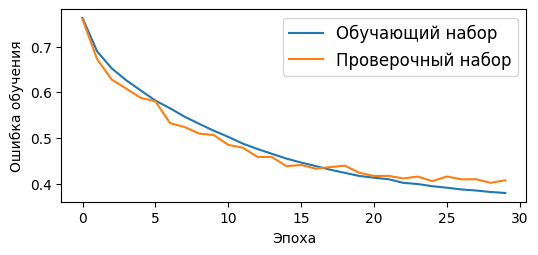

Acc =  0.6760210473565522


Epoch 1: 100%|██████████| 132/132 [00:08<00:00, 16.41it/s]


2023-06-04 23:16:24.696187 Epoch 1, Train loss 0.751, Val loss 0.825, Acc_val = 0.37


Epoch 2: 100%|██████████| 132/132 [00:08<00:00, 15.99it/s]


2023-06-04 23:16:33.156869 Epoch 2, Train loss 0.680, Val loss 0.726, Acc_val = 0.49


Epoch 3: 100%|██████████| 132/132 [00:07<00:00, 16.73it/s]


2023-06-04 23:16:41.217822 Epoch 3, Train loss 0.646, Val loss 0.708, Acc_val = 0.51


Epoch 4: 100%|██████████| 132/132 [00:07<00:00, 16.70it/s]


2023-06-04 23:16:49.326517 Epoch 4, Train loss 0.626, Val loss 0.747, Acc_val = 0.43


Epoch 5: 100%|██████████| 132/132 [00:08<00:00, 16.34it/s]


2023-06-04 23:16:57.591706 Epoch 5, Train loss 0.609, Val loss 0.709, Acc_val = 0.51


Epoch 6: 100%|██████████| 132/132 [00:08<00:00, 15.96it/s]


2023-06-04 23:17:06.078953 Epoch 6, Train loss 0.593, Val loss 0.685, Acc_val = 0.55


Epoch 7: 100%|██████████| 132/132 [00:08<00:00, 16.49it/s]


2023-06-04 23:17:14.301254 Epoch 7, Train loss 0.581, Val loss 0.656, Acc_val = 0.62


Epoch 8: 100%|██████████| 132/132 [00:07<00:00, 16.74it/s]


2023-06-04 23:17:22.372465 Epoch 8, Train loss 0.569, Val loss 0.650, Acc_val = 0.62


Epoch 9: 100%|██████████| 132/132 [00:07<00:00, 16.61it/s]


2023-06-04 23:17:30.492754 Epoch 9, Train loss 0.559, Val loss 0.644, Acc_val = 0.63


Epoch 10: 100%|██████████| 132/132 [00:08<00:00, 16.44it/s]


2023-06-04 23:17:38.719733 Epoch 10, Train loss 0.550, Val loss 0.611, Acc_val = 0.68


Epoch 11: 100%|██████████| 132/132 [00:08<00:00, 16.38it/s]


2023-06-04 23:17:46.983332 Epoch 11, Train loss 0.541, Val loss 0.629, Acc_val = 0.64


Epoch 12: 100%|██████████| 132/132 [00:07<00:00, 16.90it/s]


2023-06-04 23:17:54.982656 Epoch 12, Train loss 0.534, Val loss 0.615, Acc_val = 0.65


Epoch 13: 100%|██████████| 132/132 [00:07<00:00, 16.76it/s]


2023-06-04 23:18:03.045557 Epoch 13, Train loss 0.524, Val loss 0.572, Acc_val = 0.72


Epoch 14: 100%|██████████| 132/132 [00:07<00:00, 16.56it/s]


2023-06-04 23:18:11.202903 Epoch 14, Train loss 0.518, Val loss 0.596, Acc_val = 0.65


Epoch 15: 100%|██████████| 132/132 [00:07<00:00, 16.56it/s]


2023-06-04 23:18:19.375551 Epoch 15, Train loss 0.506, Val loss 0.572, Acc_val = 0.70


Epoch 16: 100%|██████████| 132/132 [00:07<00:00, 16.60it/s]


2023-06-04 23:18:27.515490 Epoch 16, Train loss 0.501, Val loss 0.571, Acc_val = 0.69


Epoch 17: 100%|██████████| 132/132 [00:07<00:00, 16.73it/s]


2023-06-04 23:18:35.593582 Epoch 17, Train loss 0.494, Val loss 0.589, Acc_val = 0.64


Epoch 18: 100%|██████████| 132/132 [00:08<00:00, 16.47it/s]


2023-06-04 23:18:43.779745 Epoch 18, Train loss 0.486, Val loss 0.564, Acc_val = 0.70


Epoch 19: 100%|██████████| 132/132 [00:08<00:00, 16.22it/s]


2023-06-04 23:18:52.107168 Epoch 19, Train loss 0.481, Val loss 0.559, Acc_val = 0.69


Epoch 20: 100%|██████████| 132/132 [00:07<00:00, 16.60it/s]


2023-06-04 23:19:00.262731 Epoch 20, Train loss 0.478, Val loss 0.555, Acc_val = 0.69


Epoch 21: 100%|██████████| 132/132 [00:07<00:00, 16.60it/s]


2023-06-04 23:19:08.384723 Epoch 21, Train loss 0.470, Val loss 0.556, Acc_val = 0.69


Epoch 22: 100%|██████████| 132/132 [00:08<00:00, 16.40it/s]


2023-06-04 23:19:16.621778 Epoch 22, Train loss 0.463, Val loss 0.564, Acc_val = 0.65


Epoch 23: 100%|██████████| 132/132 [00:07<00:00, 16.62it/s]


2023-06-04 23:19:24.766766 Epoch 23, Train loss 0.457, Val loss 0.582, Acc_val = 0.55


Epoch 24: 100%|██████████| 132/132 [00:07<00:00, 16.84it/s]


2023-06-04 23:19:32.806207 Epoch 24, Train loss 0.450, Val loss 0.539, Acc_val = 0.71


Epoch 25: 100%|██████████| 132/132 [00:08<00:00, 16.47it/s]


2023-06-04 23:19:41.008642 Epoch 25, Train loss 0.448, Val loss 0.531, Acc_val = 0.73


Epoch 26: 100%|██████████| 132/132 [00:07<00:00, 16.70it/s]


2023-06-04 23:19:49.098305 Epoch 26, Train loss 0.442, Val loss 0.558, Acc_val = 0.59


Epoch 27: 100%|██████████| 132/132 [00:07<00:00, 16.74it/s]


2023-06-04 23:19:57.169211 Epoch 27, Train loss 0.439, Val loss 0.585, Acc_val = 0.44


Epoch 28: 100%|██████████| 132/132 [00:07<00:00, 16.73it/s]


2023-06-04 23:20:05.262280 Epoch 28, Train loss 0.433, Val loss 0.548, Acc_val = 0.64


Epoch 29: 100%|██████████| 132/132 [00:07<00:00, 16.83it/s]


2023-06-04 23:20:13.275716 Epoch 29, Train loss 0.431, Val loss 0.539, Acc_val = 0.66


Epoch 30: 100%|██████████| 132/132 [00:07<00:00, 16.70it/s]


2023-06-04 23:20:21.349430 Epoch 30, Train loss 0.424, Val loss 0.531, Acc_val = 0.71


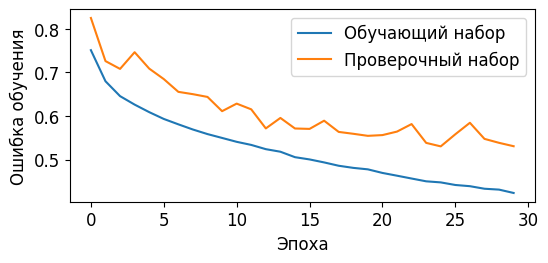

Acc =  0.84731741904987


Epoch 1: 100%|██████████| 127/127 [00:07<00:00, 16.52it/s]


2023-06-04 23:20:40.648652 Epoch 1, Train loss 0.732, Val loss 0.801, Acc_val = 0.45


Epoch 2: 100%|██████████| 127/127 [00:07<00:00, 16.78it/s]


2023-06-04 23:20:48.468732 Epoch 2, Train loss 0.654, Val loss 0.775, Acc_val = 0.52


Epoch 3: 100%|██████████| 127/127 [00:07<00:00, 16.56it/s]


2023-06-04 23:20:56.358694 Epoch 3, Train loss 0.613, Val loss 0.755, Acc_val = 0.56


Epoch 4: 100%|██████████| 127/127 [00:07<00:00, 16.57it/s]


2023-06-04 23:21:04.271411 Epoch 4, Train loss 0.581, Val loss 0.746, Acc_val = 0.58


Epoch 5: 100%|██████████| 127/127 [00:07<00:00, 16.62it/s]


2023-06-04 23:21:12.145601 Epoch 5, Train loss 0.558, Val loss 0.729, Acc_val = 0.58


Epoch 6: 100%|██████████| 127/127 [00:07<00:00, 16.17it/s]


2023-06-04 23:21:20.235623 Epoch 6, Train loss 0.533, Val loss 0.718, Acc_val = 0.60


Epoch 7: 100%|██████████| 127/127 [00:07<00:00, 16.39it/s]


2023-06-04 23:21:28.236055 Epoch 7, Train loss 0.515, Val loss 0.708, Acc_val = 0.60


Epoch 8: 100%|██████████| 127/127 [00:07<00:00, 16.59it/s]


2023-06-04 23:21:36.126015 Epoch 8, Train loss 0.498, Val loss 0.691, Acc_val = 0.61


Epoch 9: 100%|██████████| 127/127 [00:07<00:00, 16.68it/s]


2023-06-04 23:21:43.975200 Epoch 9, Train loss 0.480, Val loss 0.683, Acc_val = 0.63


Epoch 10: 100%|██████████| 127/127 [00:07<00:00, 16.76it/s]


2023-06-04 23:21:51.802876 Epoch 10, Train loss 0.466, Val loss 0.668, Acc_val = 0.63


Epoch 11: 100%|██████████| 127/127 [00:07<00:00, 16.76it/s]


2023-06-04 23:21:59.630342 Epoch 11, Train loss 0.453, Val loss 0.656, Acc_val = 0.66


Epoch 12: 100%|██████████| 127/127 [00:07<00:00, 16.84it/s]


2023-06-04 23:22:07.453019 Epoch 12, Train loss 0.442, Val loss 0.647, Acc_val = 0.67


Epoch 13: 100%|██████████| 127/127 [00:07<00:00, 16.48it/s]


2023-06-04 23:22:15.439931 Epoch 13, Train loss 0.435, Val loss 0.634, Acc_val = 0.68


Epoch 14: 100%|██████████| 127/127 [00:07<00:00, 16.60it/s]


2023-06-04 23:22:23.356801 Epoch 14, Train loss 0.426, Val loss 0.624, Acc_val = 0.70


Epoch 15: 100%|██████████| 127/127 [00:07<00:00, 16.61it/s]


2023-06-04 23:22:31.254925 Epoch 15, Train loss 0.419, Val loss 0.615, Acc_val = 0.71


Epoch 16: 100%|██████████| 127/127 [00:07<00:00, 16.52it/s]


2023-06-04 23:22:39.207378 Epoch 16, Train loss 0.411, Val loss 0.605, Acc_val = 0.72


Epoch 17: 100%|██████████| 127/127 [00:07<00:00, 16.62it/s]


2023-06-04 23:22:47.097338 Epoch 17, Train loss 0.403, Val loss 0.596, Acc_val = 0.74


Epoch 18: 100%|██████████| 127/127 [00:07<00:00, 16.42it/s]


2023-06-04 23:22:55.054934 Epoch 18, Train loss 0.398, Val loss 0.587, Acc_val = 0.74


Epoch 19: 100%|██████████| 127/127 [00:07<00:00, 16.52it/s]


2023-06-04 23:23:02.960516 Epoch 19, Train loss 0.394, Val loss 0.577, Acc_val = 0.73


Epoch 20: 100%|██████████| 127/127 [00:07<00:00, 16.66it/s]


2023-06-04 23:23:10.834852 Epoch 20, Train loss 0.389, Val loss 0.575, Acc_val = 0.75


Epoch 21: 100%|██████████| 127/127 [00:07<00:00, 16.40it/s]


2023-06-04 23:23:18.844945 Epoch 21, Train loss 0.386, Val loss 0.565, Acc_val = 0.75


Epoch 22: 100%|██████████| 127/127 [00:07<00:00, 16.65it/s]


2023-06-04 23:23:26.690171 Epoch 22, Train loss 0.384, Val loss 0.562, Acc_val = 0.77


Epoch 23: 100%|██████████| 127/127 [00:07<00:00, 16.55it/s]


2023-06-04 23:23:34.596823 Epoch 23, Train loss 0.379, Val loss 0.560, Acc_val = 0.78


Epoch 24: 100%|██████████| 127/127 [00:07<00:00, 16.69it/s]


2023-06-04 23:23:42.455536 Epoch 24, Train loss 0.376, Val loss 0.548, Acc_val = 0.77


Epoch 25: 100%|██████████| 127/127 [00:07<00:00, 16.76it/s]


2023-06-04 23:23:50.253132 Epoch 25, Train loss 0.373, Val loss 0.549, Acc_val = 0.80


Epoch 26: 100%|██████████| 127/127 [00:07<00:00, 16.74it/s]


2023-06-04 23:23:58.074326 Epoch 26, Train loss 0.370, Val loss 0.540, Acc_val = 0.78


Epoch 27: 100%|██████████| 127/127 [00:07<00:00, 16.49it/s]


2023-06-04 23:24:06.011163 Epoch 27, Train loss 0.370, Val loss 0.534, Acc_val = 0.78


Epoch 28: 100%|██████████| 127/127 [00:07<00:00, 16.65it/s]


2023-06-04 23:24:13.894234 Epoch 28, Train loss 0.366, Val loss 0.536, Acc_val = 0.80


Epoch 29: 100%|██████████| 127/127 [00:07<00:00, 16.24it/s]


2023-06-04 23:24:21.986217 Epoch 29, Train loss 0.363, Val loss 0.531, Acc_val = 0.79


Epoch 30: 100%|██████████| 127/127 [00:07<00:00, 16.70it/s]


2023-06-04 23:24:29.855725 Epoch 30, Train loss 0.361, Val loss 0.529, Acc_val = 0.80


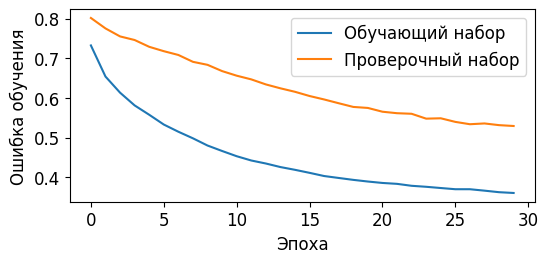

Acc =  0.5920810313075506


Epoch 1: 100%|██████████| 137/137 [00:08<00:00, 16.57it/s]


2023-06-04 23:24:50.019153 Epoch 1, Train loss 0.754, Val loss 0.781, Acc_val = 0.52


Epoch 2: 100%|██████████| 137/137 [00:08<00:00, 16.59it/s]


2023-06-04 23:24:58.497583 Epoch 2, Train loss 0.670, Val loss 0.725, Acc_val = 0.58


Epoch 3: 100%|██████████| 137/137 [00:08<00:00, 16.56it/s]


2023-06-04 23:25:06.989928 Epoch 3, Train loss 0.630, Val loss 0.667, Acc_val = 0.66


Epoch 4: 100%|██████████| 137/137 [00:08<00:00, 16.43it/s]


2023-06-04 23:25:15.546818 Epoch 4, Train loss 0.603, Val loss 0.637, Acc_val = 0.69


Epoch 5: 100%|██████████| 137/137 [00:08<00:00, 16.75it/s]


2023-06-04 23:25:23.929977 Epoch 5, Train loss 0.578, Val loss 0.608, Acc_val = 0.72


Epoch 6: 100%|██████████| 137/137 [00:08<00:00, 16.60it/s]


2023-06-04 23:25:32.388129 Epoch 6, Train loss 0.559, Val loss 0.563, Acc_val = 0.80


Epoch 7: 100%|██████████| 137/137 [00:08<00:00, 16.57it/s]


2023-06-04 23:25:40.873320 Epoch 7, Train loss 0.541, Val loss 0.536, Acc_val = 0.85


Epoch 8: 100%|██████████| 137/137 [00:08<00:00, 16.51it/s]


2023-06-04 23:25:49.388227 Epoch 8, Train loss 0.524, Val loss 0.506, Acc_val = 0.88


Epoch 9: 100%|██████████| 137/137 [00:08<00:00, 16.18it/s]


2023-06-04 23:25:58.098430 Epoch 9, Train loss 0.511, Val loss 0.492, Acc_val = 0.87


Epoch 10: 100%|██████████| 137/137 [00:08<00:00, 15.59it/s]


2023-06-04 23:26:07.120764 Epoch 10, Train loss 0.495, Val loss 0.458, Acc_val = 0.91


Epoch 11: 100%|██████████| 137/137 [00:08<00:00, 16.31it/s]


2023-06-04 23:26:15.706005 Epoch 11, Train loss 0.486, Val loss 0.437, Acc_val = 0.93


Epoch 12: 100%|██████████| 137/137 [00:08<00:00, 16.59it/s]


2023-06-04 23:26:24.155141 Epoch 12, Train loss 0.473, Val loss 0.411, Acc_val = 0.96


Epoch 13: 100%|██████████| 137/137 [00:08<00:00, 16.44it/s]


2023-06-04 23:26:32.690405 Epoch 13, Train loss 0.461, Val loss 0.391, Acc_val = 0.97


Epoch 14: 100%|██████████| 137/137 [00:08<00:00, 16.80it/s]


2023-06-04 23:26:41.049078 Epoch 14, Train loss 0.450, Val loss 0.375, Acc_val = 0.97


Epoch 15: 100%|██████████| 137/137 [00:08<00:00, 16.83it/s]


2023-06-04 23:26:49.407749 Epoch 15, Train loss 0.438, Val loss 0.361, Acc_val = 0.98


Epoch 16: 100%|██████████| 137/137 [00:08<00:00, 16.66it/s]


2023-06-04 23:26:57.853811 Epoch 16, Train loss 0.430, Val loss 0.341, Acc_val = 0.99


Epoch 17: 100%|██████████| 137/137 [00:08<00:00, 16.51it/s]


2023-06-04 23:27:06.372126 Epoch 17, Train loss 0.419, Val loss 0.327, Acc_val = 0.99


Epoch 18: 100%|██████████| 137/137 [00:08<00:00, 16.53it/s]


2023-06-04 23:27:14.862309 Epoch 18, Train loss 0.411, Val loss 0.311, Acc_val = 0.99


Epoch 19: 100%|██████████| 137/137 [00:08<00:00, 16.54it/s]


2023-06-04 23:27:23.349456 Epoch 19, Train loss 0.400, Val loss 0.302, Acc_val = 0.99


Epoch 20: 100%|██████████| 137/137 [00:08<00:00, 16.71it/s]


2023-06-04 23:27:31.751871 Epoch 20, Train loss 0.393, Val loss 0.292, Acc_val = 0.99


Epoch 21: 100%|██████████| 137/137 [00:08<00:00, 16.47it/s]


2023-06-04 23:27:40.305358 Epoch 21, Train loss 0.385, Val loss 0.284, Acc_val = 0.99


Epoch 22: 100%|██████████| 137/137 [00:08<00:00, 16.67it/s]


2023-06-04 23:27:48.728431 Epoch 22, Train loss 0.377, Val loss 0.274, Acc_val = 1.00


Epoch 23: 100%|██████████| 137/137 [00:08<00:00, 16.58it/s]


2023-06-04 23:27:57.227715 Epoch 23, Train loss 0.368, Val loss 0.262, Acc_val = 1.00


Epoch 24: 100%|██████████| 137/137 [00:08<00:00, 16.76it/s]


2023-06-04 23:28:05.607127 Epoch 24, Train loss 0.361, Val loss 0.255, Acc_val = 1.00


Epoch 25: 100%|██████████| 137/137 [00:08<00:00, 16.42it/s]


2023-06-04 23:28:14.161262 Epoch 25, Train loss 0.356, Val loss 0.253, Acc_val = 1.00


Epoch 26: 100%|██████████| 137/137 [00:08<00:00, 16.54it/s]


2023-06-04 23:28:22.660547 Epoch 26, Train loss 0.349, Val loss 0.247, Acc_val = 1.00


Epoch 27: 100%|██████████| 137/137 [00:08<00:00, 16.45it/s]


2023-06-04 23:28:31.193900 Epoch 27, Train loss 0.346, Val loss 0.240, Acc_val = 1.00


Epoch 28: 100%|██████████| 137/137 [00:08<00:00, 16.50it/s]


2023-06-04 23:28:39.733440 Epoch 28, Train loss 0.339, Val loss 0.239, Acc_val = 1.00


Epoch 29: 100%|██████████| 137/137 [00:08<00:00, 16.39it/s]


2023-06-04 23:28:48.326466 Epoch 29, Train loss 0.332, Val loss 0.232, Acc_val = 1.00


Epoch 30: 100%|██████████| 137/137 [00:08<00:00, 15.80it/s]


2023-06-04 23:28:57.216195 Epoch 30, Train loss 0.327, Val loss 0.230, Acc_val = 1.00


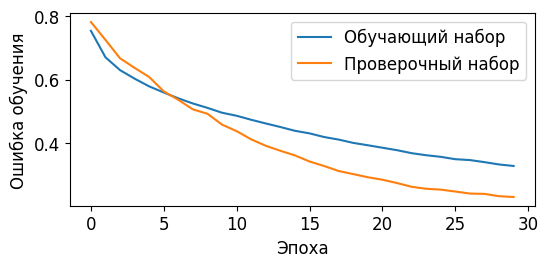

Acc =  0.7494356659142212


Epoch 1: 100%|██████████| 125/125 [00:07<00:00, 16.35it/s]


2023-06-04 23:29:14.698293 Epoch 1, Train loss 0.753, Val loss 0.651, Acc_val = 0.66


Epoch 2: 100%|██████████| 125/125 [00:07<00:00, 16.46it/s]


2023-06-04 23:29:22.650746 Epoch 2, Train loss 0.689, Val loss 0.610, Acc_val = 0.75


Epoch 3: 100%|██████████| 125/125 [00:07<00:00, 16.52it/s]


2023-06-04 23:29:30.559791 Epoch 3, Train loss 0.658, Val loss 0.590, Acc_val = 0.78


Epoch 4: 100%|██████████| 125/125 [00:07<00:00, 16.61it/s]


2023-06-04 23:29:38.415249 Epoch 4, Train loss 0.637, Val loss 0.547, Acc_val = 0.85


Epoch 5: 100%|██████████| 125/125 [00:07<00:00, 16.60it/s]


2023-06-04 23:29:46.305213 Epoch 5, Train loss 0.623, Val loss 0.541, Acc_val = 0.86


Epoch 6: 100%|██████████| 125/125 [00:07<00:00, 16.56it/s]


2023-06-04 23:29:54.195336 Epoch 6, Train loss 0.609, Val loss 0.533, Acc_val = 0.86


Epoch 7: 100%|██████████| 125/125 [00:07<00:00, 16.56it/s]


2023-06-04 23:30:02.086404 Epoch 7, Train loss 0.595, Val loss 0.537, Acc_val = 0.85


Epoch 8: 100%|██████████| 125/125 [00:07<00:00, 16.73it/s]


2023-06-04 23:30:09.916938 Epoch 8, Train loss 0.582, Val loss 0.521, Acc_val = 0.87


Epoch 9: 100%|██████████| 125/125 [00:07<00:00, 16.44it/s]


2023-06-04 23:30:17.840719 Epoch 9, Train loss 0.571, Val loss 0.506, Acc_val = 0.88


Epoch 10: 100%|██████████| 125/125 [00:07<00:00, 16.24it/s]


2023-06-04 23:30:25.896574 Epoch 10, Train loss 0.560, Val loss 0.505, Acc_val = 0.88


Epoch 11: 100%|██████████| 125/125 [00:07<00:00, 16.49it/s]


2023-06-04 23:30:33.833797 Epoch 11, Train loss 0.549, Val loss 0.502, Acc_val = 0.88


Epoch 12: 100%|██████████| 125/125 [00:07<00:00, 16.50it/s]


2023-06-04 23:30:41.767064 Epoch 12, Train loss 0.539, Val loss 0.515, Acc_val = 0.85


Epoch 13: 100%|██████████| 125/125 [00:07<00:00, 16.72it/s]


2023-06-04 23:30:49.600954 Epoch 13, Train loss 0.527, Val loss 0.497, Acc_val = 0.89


Epoch 14: 100%|██████████| 125/125 [00:07<00:00, 16.55it/s]


2023-06-04 23:30:57.495738 Epoch 14, Train loss 0.517, Val loss 0.485, Acc_val = 0.91


Epoch 15: 100%|██████████| 125/125 [00:07<00:00, 16.37it/s]


2023-06-04 23:31:05.445569 Epoch 15, Train loss 0.510, Val loss 0.482, Acc_val = 0.92


Epoch 16: 100%|██████████| 125/125 [00:07<00:00, 16.60it/s]


2023-06-04 23:31:13.337248 Epoch 16, Train loss 0.499, Val loss 0.478, Acc_val = 0.92


Epoch 17: 100%|██████████| 125/125 [00:07<00:00, 16.49it/s]


2023-06-04 23:31:21.278810 Epoch 17, Train loss 0.492, Val loss 0.472, Acc_val = 0.93


Epoch 18: 100%|██████████| 125/125 [00:07<00:00, 16.33it/s]


2023-06-04 23:31:29.243745 Epoch 18, Train loss 0.483, Val loss 0.477, Acc_val = 0.92


Epoch 19: 100%|██████████| 125/125 [00:07<00:00, 16.58it/s]


2023-06-04 23:31:37.128781 Epoch 19, Train loss 0.475, Val loss 0.465, Acc_val = 0.95


Epoch 20: 100%|██████████| 125/125 [00:07<00:00, 16.09it/s]


2023-06-04 23:31:45.278765 Epoch 20, Train loss 0.467, Val loss 0.465, Acc_val = 0.95


Epoch 21: 100%|██████████| 125/125 [00:08<00:00, 14.73it/s]


2023-06-04 23:31:54.131387 Epoch 21, Train loss 0.460, Val loss 0.453, Acc_val = 0.97


Epoch 22: 100%|██████████| 125/125 [00:08<00:00, 15.51it/s]


2023-06-04 23:32:02.551694 Epoch 22, Train loss 0.452, Val loss 0.455, Acc_val = 0.97


Epoch 23: 100%|██████████| 125/125 [00:08<00:00, 14.99it/s]


2023-06-04 23:32:11.305893 Epoch 23, Train loss 0.447, Val loss 0.461, Acc_val = 0.95


Epoch 24: 100%|██████████| 125/125 [00:08<00:00, 15.30it/s]


2023-06-04 23:32:19.834165 Epoch 24, Train loss 0.441, Val loss 0.456, Acc_val = 0.95


Epoch 25: 100%|██████████| 125/125 [00:08<00:00, 15.26it/s]


2023-06-04 23:32:28.390429 Epoch 25, Train loss 0.435, Val loss 0.444, Acc_val = 0.98


Epoch 26: 100%|██████████| 125/125 [00:07<00:00, 15.78it/s]


2023-06-04 23:32:36.667782 Epoch 26, Train loss 0.429, Val loss 0.441, Acc_val = 0.98


Epoch 27: 100%|██████████| 125/125 [00:07<00:00, 15.80it/s]


2023-06-04 23:32:44.946133 Epoch 27, Train loss 0.424, Val loss 0.447, Acc_val = 0.97


Epoch 28: 100%|██████████| 125/125 [00:07<00:00, 15.69it/s]


2023-06-04 23:32:53.252476 Epoch 28, Train loss 0.420, Val loss 0.443, Acc_val = 0.98


Epoch 29: 100%|██████████| 125/125 [00:07<00:00, 15.86it/s]


2023-06-04 23:33:01.493840 Epoch 29, Train loss 0.415, Val loss 0.437, Acc_val = 0.98


Epoch 30: 100%|██████████| 125/125 [00:07<00:00, 15.70it/s]


2023-06-04 23:33:09.793186 Epoch 30, Train loss 0.412, Val loss 0.435, Acc_val = 0.99


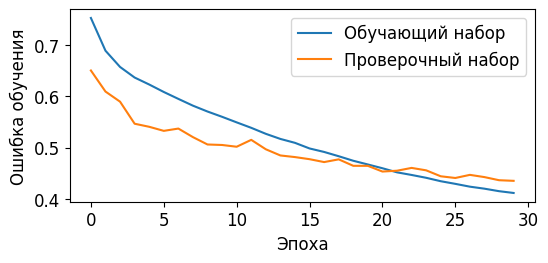

Acc =  0.8313492063492064
Final results
30 epochs. Acc_sk = 0.73 (Sens = 0.76 / Spec = 0.70) 0.68 / 0.85 / 0.59 / 0.75 / 0.83


C:\Users\Tanya\AppData\Local\Temp\ipykernel_13340\1709305254.py:97: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,len(folds),i+1)


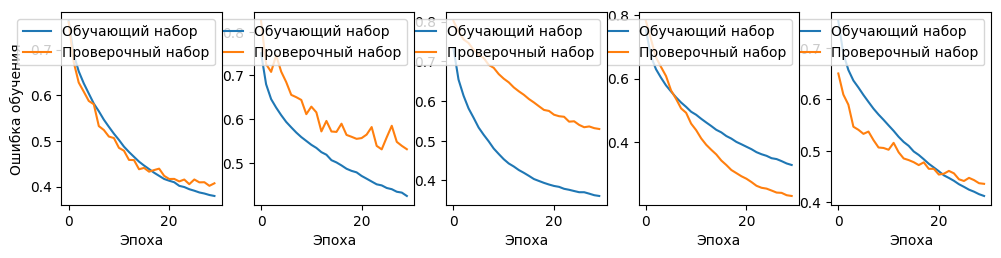

In [10]:
import os
model_dir = 'model_backup'
if not os.path.exists(model_dir):  
  os.makedirs(model_dir)

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
model = ALS_CNN1()

# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 40 epochs. Acc_sk = 0.70 (Sens = 0.74 / Spec = 0.66) 0.68 / 0.86 / 0.52 / 0.76 / 0.77
# self.layer1_filt = 2 (before 8)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.66 (Sens = 0.62 / Spec = 0.70) 0.68 / 0.55 / 0.57 / 0.62 / 0.88
# max_pool_width = 4 (before 1)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.9) # 15 epochs. Acc_sk = 0.59 (Sens = 0.53 / Spec = 0.65) 0.65 / 0.50 / 0.56 / 0.61 / 0.63
# self.layer1_filt = 4 + max_pool_width = 4 + lf1_height, lf1_width = 29,43
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.65 (Sens = 0.61 / Spec = 0.69) 0.61 / 0.62 / 0.60 / 0.65 / 0.75 (good behaviour)
# mf2_height,mf2_width = 15,43 (before 15x17)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.70) 0.71 / 0.69 / 0.53 / 0.75 / 0.90
# hf4_height,hf4_width = 15,43 (before 15x15)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.76 / Spec = 0.64) 0.73 / 0.66 / 0.53 / 0.73 / 0.86
# hf4_height,hf4_width = 15,31 (before 15x43)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.71 (Sens = 0.77 / Spec = 0.64) 0.67 / 0.79 / 0.51 / 0.68 / 0.89
# hf3_height,hf3_width = 13,27 (before 11x11)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.81 / Spec = 0.70) 0.78 / 0.86 / 0.53 / 0.74 / 0.89
# mf_height,mf_width = 13,27 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.76 (Sens = 0.77 / Spec = 0.75) 0.78 / 0.82 / 0.62 / 0.73 / 0.88
# lf3_height, lf3_width = 13,27 (3x7)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.73) 0.72 / 0.81 / 0.65 / 0.72 / 0.87
# lf3_height, lf3_width = 25,39 (13x27)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.72 (Sens = 0.73 / Spec = 0.72) 0.65 / 0.67 / 0.62 / 0.74 / 0.92  (good behaviour)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.6) # 15 epochs. Acc_sk = 0.74 (Sens = 0.76 / Spec = 0.72) 0.69 / 0.79 / 0.63 / 0.71 / 0.88
# lf3_height, lf3_width = 5,11
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.75 / Spec = 0.72) 0.63 / 0.82 / 0.64 / 0.75 / 0.88
# model with diff input. Now there is 2 input chanells: x and x_diff
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.70 (Sens = 0.66 / Spec = 0.76) 0.69 / 0.66 / 0.58 / 0.67 / 0.91
# self.layer1_filt = 6 (before 4)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.78 (Sens = 0.80 / Spec = 0.76) 0.70 / 0.80 / 0.69 / 0.74 / 0.93
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.5) # 30 epochs. Acc_sk = 0.77 (Sens = 0.79 / Spec = 0.74) 0.71 / 0.79 / 0.65 / 0.76 / 0.90
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.3) # 30 epochs. Acc_sk = 0.77 (Sens = 0.76 / Spec = 0.77) 0.70 / 0.74 / 0.68 / 0.72 / 0.94
# optimizer = optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-1) # 20 epochs. Acc_sk = 0.71 (Sens = 0.69 / Spec = 0.74) 0.66 / 0.80 / 0.64 / 0.71 / 0.81
# hf_height,hf_width = 9,9 (before 3x3)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.75 (Sens = 0.76 / Spec = 0.75) 0.66 / 0.82 / 0.61 / 0.74 / 0.93
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.75 (Sens = 0.75 / Spec = 0.74) 0.75 / 0.78 / 0.62 / 0.72 / 0.87
# hf_height,hf_width = 3,3 (return)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 35 epochs. Acc_sk = 0.77 (Sens = 0.78 / Spec = 0.75) 0.70 / 0.82 / 0.66 / 0.75 / 0.89 (32 min)
# big context on each subband
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.68 (Sens = 0.72 / Spec = 0.64) 0.60 / 0.80 / 0.57 / 0.70 / 0.78
# hf2_height,hf2_width = 13,27 (15x31)
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 15 epochs. Acc_sk = 0.69 (Sens = 0.71 / Spec = 0.67) 0.66 / 0.73 / 0.57 / 0.68 / 0.83
# optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4) # 30 epochs. Acc_sk = 0.73 (Sens = 0.76 / Spec = 0.70) 0.68 / 0.85 / 0.59 / 0.75 / 0.83
# mf2_height,mf2_width = 11,31 (15x43)
optimizer = optim.SGD(model.parameters(),lr=1e-3, weight_decay=1e-1, momentum=0.4)

k_fold_CV(dataset=DataSet_ALS, model = model, optimizer=optimizer, train = training_loop, n_epochs=15)

In [60]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))

#Test 4
# x = torch.randn(3)
# x3 = torch.cat((x, x, x), 0)
# print(x3)

#Test 5
A = np.random.random((2,3))
print(A.shape)
A = A.reshape((1,A.shape[0],A.shape[1]))
print(A.shape)

torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])
(2, 3)
(1, 2, 3)


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
